In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()


Rolling Volatility

In [2]:
# IWM ticker object
iwm = yf.Ticker("IWM")

# get historical market data from 2000-01-01 ,actions = F
hist = iwm.history(start="2000-01-01", actions=False)

#keep close
iwm = hist['Close']
iwm.head()

Date
2000-05-26 00:00:00-04:00    33.483601
2000-05-30 00:00:00-04:00    34.719509
2000-05-31 00:00:00-04:00    34.845341
2000-06-01 00:00:00-04:00    35.634968
2000-06-02 00:00:00-04:00    37.488804
Name: Close, dtype: float64

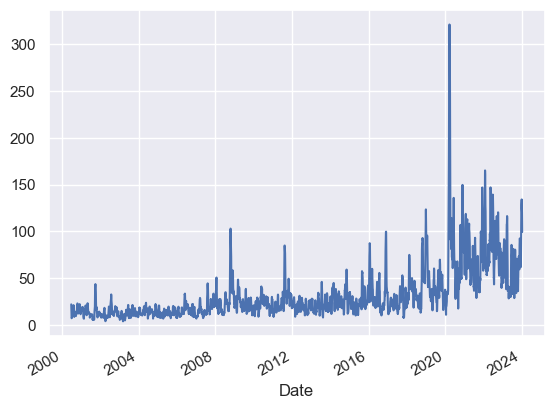

In [4]:
#20 day rolling volatility
volatility = iwm.rolling(20).std() * np.sqrt(252)
volatility.plot()
plt.show()

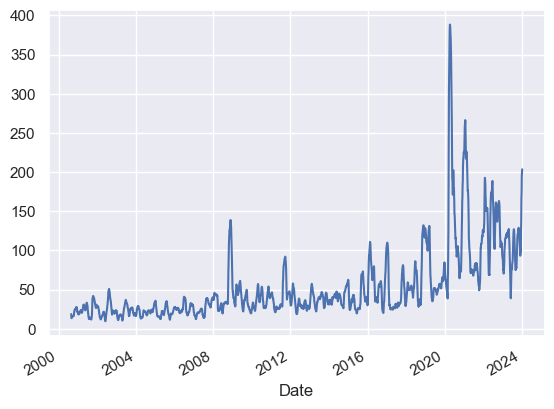

In [5]:
#rolling 60 day volatility
volatility = iwm.rolling(60).std() * np.sqrt(252)
volatility.plot()
plt.show()

EWMA Volatility

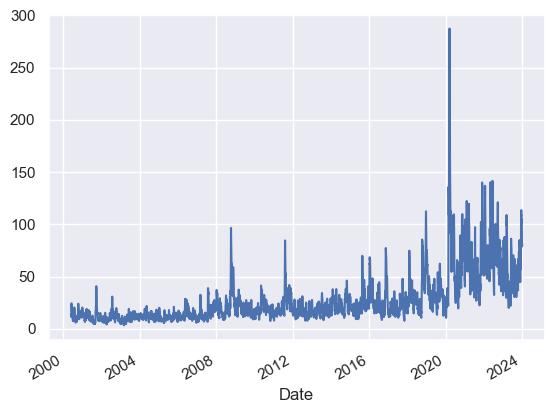

In [9]:
#EWMA volatility

#alpha param
alpha = 0.2
#보통 0.1, 0.2를 사용 
#EWMA volatility
ewma_vol = iwm.ewm(alpha=alpha).std() * np.sqrt(252)
ewma_vol.plot()
plt.show()

OHLC volatility

In [11]:
# IWM ticker object
iwm = yf.Ticker("IWM")

# get historical market data from 2000-01-01 ,actions = F
hist = iwm.history(start="2000-01-01", actions=False)

#drop Volume
hist = hist.drop(columns=['Volume'])
iwm_ohlc = hist.copy()

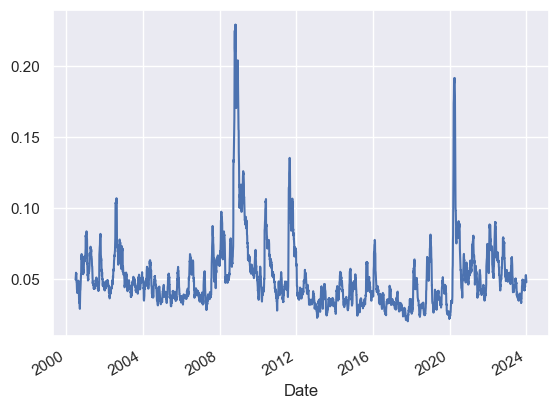

In [15]:
param = 20
#Parkinson (1980) volatility
vol_p = np.sqrt((1/(4*np.log(2))) * pd.DataFrame.rolling(np.log(hist['High']/hist['Low'])**2,20).sum())
vol_p.plot()
plt.show()

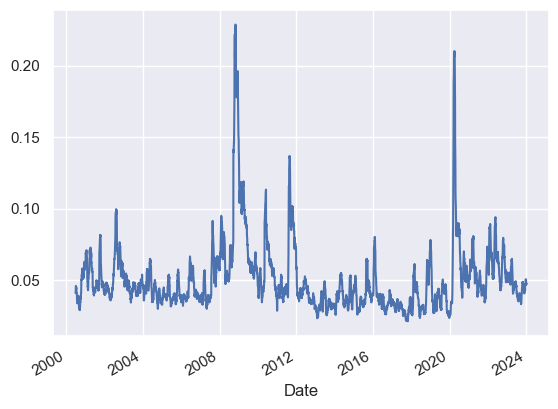

In [18]:
#Garman-Klass (1980) volatility
#first term
first = (1/2) * pd.DataFrame.rolling(np.log(hist['High']/hist['Low'])**2,20).sum()
#second term
second = (2*np.log(2)-1) * (pd.DataFrame.rolling(np.log(hist['Close']/hist['Open'])**2,20).sum())

vol_gk = np.sqrt(first - second)
vol_gk.plot()
plt.show()

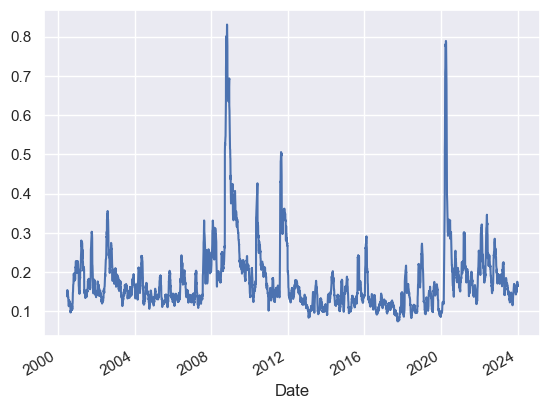

In [21]:
#Rogers-Satchell (1991) volatility
#first term
term1 = np.log(hist['High']/hist['Close']) * np.log(hist['High']/hist['Open'])+np.log(hist['Low']/hist['Close']) * np.log(hist['Low']/hist['Open'])
vol_rs = np.sqrt((252/param) * pd.DataFrame.rolling(term1,20).sum())
vol_rs.plot()
plt.show()

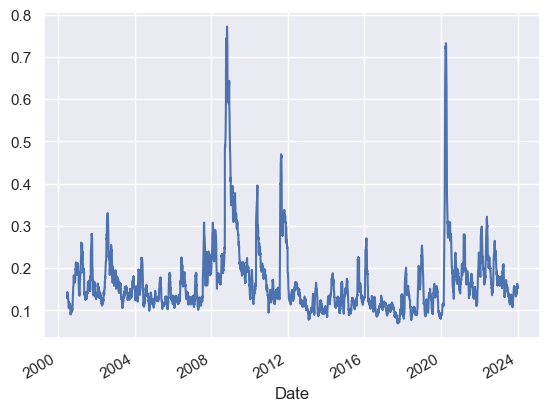

In [22]:
#Yang-Zhang (2000) volatility
alpha =1.34
kappa = (alpha-1)/(alpha + ((param+1)/(param-1)))
#Overnight volatility

vol_o = np.log(hist['Open']/hist['Close'].shift(1))
vol_c = np.log(hist['Close']/hist['Open'])
vol_yz = np.sqrt(vol_o **2 + kappa*vol_c**2 + (1-kappa)*vol_rs**2)
vol_yz.plot()
plt.show()

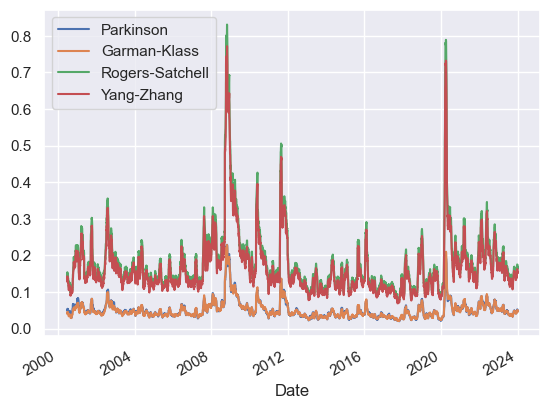

In [23]:
#Model comparison visualization
vol_p.plot(label='Parkinson')
vol_gk.plot(label='Garman-Klass')
vol_rs.plot(label='Rogers-Satchell')
vol_yz.plot(label='Yang-Zhang')
plt.legend()
plt.show()

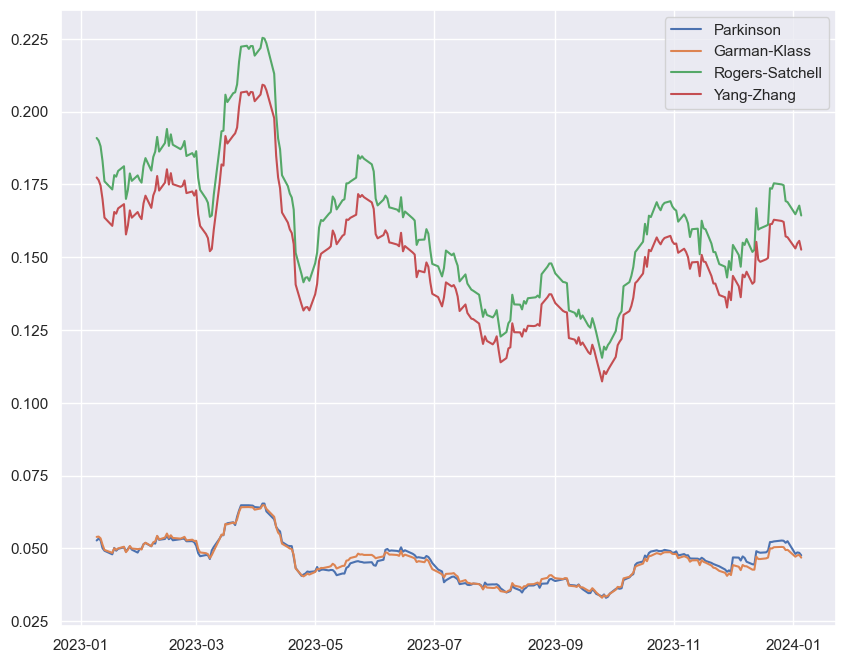

In [24]:
#figure size 10,8
plt.figure(figsize=(10,8))
#recent 250 days
plt.plot(vol_p[-250:],label='Parkinson')
plt.plot(vol_gk[-250:],label='Garman-Klass')
plt.plot(vol_rs[-250:],label='Rogers-Satchell')
plt.plot(vol_yz[-250:],label='Yang-Zhang')
plt.legend()
plt.show()


GARCH 모델

In [27]:
import math
from scipy.stats import norm
from scipy.optimize import minimize, Bounds, LinearConstraint

from arch import arch_model
import scipy
sns.set()

In [49]:
#GARCH(1,1) model class

class garchOneOne:
    
    def __init__(self, rets):
        #return
        self.rets = rets*100
        #variance
        self.sigma2 = self.garch_filter(self.garch_optimization())
        #GARCH model coefficient
        self.coefficients = self.garch_optimization()
        
    def garch_filter(self, parameters):
        
        #parameter value
        alpha = parameters[0]
        beta = parameters[1]
        delta = parameters[2]
        #initilize sigma2
        length = len(self.rets)    
        sigma2 = np.zeros(length)
                
        #fill the arrray , if i is 0, use the variance of the long term variance
        for i in range(length):
            if i == 0:
                sigma2[i] = alpha / (1 - beta - delta)
            else:
                sigma2[i] = alpha + beta*self.rets[i-1]**2 + delta * sigma2[i-1]
        return sigma2
    
    #log likelihood function of GARCH(1,1)
    def garch_loglikehood(self, parameters):
        #length of data
        length = len(self.rets)
        #variance
        sigma2 = self.garch_filter(parameters)
        #log likelihood
        log_likelihood = -np.sum(-np.log(sigma2) - self.rets**2/sigma2)
        return log_likelihood
    
    #Optimize the GARCH model
    def garch_optimization(self):
        #initialize the parameter
        parameters = np.array([0.1,0.05,0.90])
        #alpha =0.1 , beta =0.05, delta =0.9 
        #constraint
        bounds = ((0.001,1), (0.001,1), (0.001,1))  
        #optimization
        result = scipy.optimize.minimize(self.garch_loglikehood, parameters, bounds=bounds)
        
        #variance
        variance = 0.01**2 + result.x[0] / ( 1 - result.x[1] - result.x[2])
        
        return np.append(result.x, variance)
                

In [73]:
#SPX
SPX = yf.download('^GSPC', start='2000-01-01', end='2015-12-31', interval = '1d')
VIX = yf.download('^VIX', start='2000-01-01', end='2015-12-31', interval = '1d')

ret_spx= SPX['Close'].pct_change().dropna()
ret_spx


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Date
2000-01-04   -0.038345
2000-01-05    0.001922
2000-01-06    0.000956
2000-01-07    0.027090
2000-01-10    0.011190
                ...   
2015-12-23    0.012418
2015-12-24   -0.001599
2015-12-28   -0.002179
2015-12-29    0.010630
2015-12-30   -0.007217
Name: Close, Length: 4023, dtype: float64

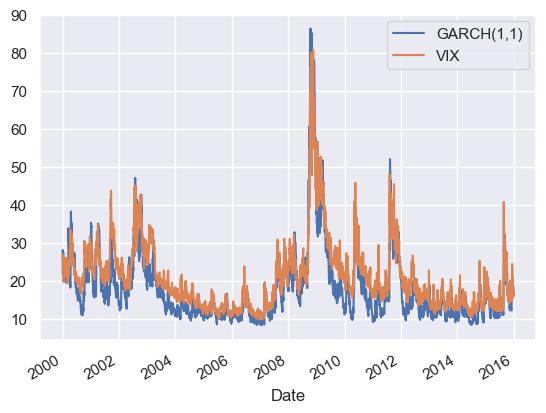

In [74]:
#Perform GARCH(1,1) model 
modelSPX = garchOneOne(ret_spx)

res = pd.DataFrame(np.sqrt(modelSPX.sigma2 *252 ), index = ret_spx.index, columns=['GARCH(1,1)'])
#Compare with VIX
res['VIX'] = VIX['Close']
res.plot()
plt.show()


In [77]:
#using arch package
from arch import arch_model
#multply 100
ret_spx = ret_spx*100
arch_spx = arch_model(ret_spx, mean='Zero', vol='GARCH')
res = arch_spx.fit()
res.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 2166971073.8435273
Iteration:      2,   Func. Count:     12,   Neg. LLF: 955234700.2177491
Iteration:      3,   Func. Count:     17,   Neg. LLF: 5692.426831844569
Iteration:      4,   Func. Count:     22,   Neg. LLF: 5662.464074126876
Iteration:      5,   Func. Count:     27,   Neg. LLF: 5707.194882405248
Iteration:      6,   Func. Count:     32,   Neg. LLF: 5649.3035835974315
Iteration:      7,   Func. Count:     36,   Neg. LLF: 5649.2955673156075
Iteration:      8,   Func. Count:     40,   Neg. LLF: 5649.29549198421
Iteration:      9,   Func. Count:     43,   Neg. LLF: 5649.295491981371
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5649.29549198421
            Iterations: 9
            Function evaluations: 43
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5649.30
Distribution:                  Normal   AIC:                           11304.6
Method:            Maximum Likelihood   BIC:                           11323.5
                                        No. Observations:                 4023
Date:                Mon, Jan 08 2024   Df Residuals:                     4023
Time:                        20:16:55   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0161  4.563e-03      3.535  4.074e-04 [7.187e-03,2.507e-02]
alpha[1]       0.0841  1.038e-02      8.101  5.434e-16   [6.373e-02,  0.104]
beta[1]        0.9022  1.197e-02     75.396      0.000     [  0.879,  0.926]
============================================================================

Covariance estimator: robust
"""

In [82]:
#confidence interval to dataframe
conf_int = pd.DataFrame(res.conf_int(0.2))
# #Test 
conf_int['Test'] = res.params
conf_int.columns = ['Lower','Upper','Test']
conf_int
#Pass or fail
conf_int['Pass'] = np.where((conf_int['Test'] > conf_int['Lower']) & (conf_int['Test'] < conf_int['Upper']), 'Pass', 'Fail')
conf_int

,Lower,Upper,Test,Pass
omega,0.010283,0.021978,0.016130,Pass
alpha[1],0.070773,0.097372,0.084073,Pass
beta[1],0.886848,0.917518,0.902183,Pass
